In [1]:
import joblib
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import os
import seaborn as sns

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device="cpu"
print(device)

cuda


In [3]:
n_samples = 410
n_input_G = 8

In [4]:
class Generator(nn.Module):
  def __init__(self, n_input, n_hidden_size, n_output=4, activation=nn.Tanh()):
    super(Generator, self).__init__()
    self.linear1 = nn.Linear(n_input, n_hidden_size)
    # Hack 4 : Use batch normalization : doesn't work
    self.batchnorm1 = nn.BatchNorm1d(n_hidden_size)
    self.relu1 = nn.LeakyReLU()
    # Hack 17 : Use dropout in both train and test
    self.dropout1 = nn.Dropout()
    self.linear2 = nn.Linear(n_hidden_size, n_output)
    # Hack 1 : Use tanh for the generator
    self.activation = activation

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.linear2(x)
    return self.activation(x)

In [5]:
model = torch.load("model/generator_model_distribution_shifting", map_location="cpu")

In [6]:
scaler = joblib.load('model/scaler.gz')

In [7]:
# torch.manual_seed(42)
# Noise generation
# noisy_input = Variable(torch.randn(n_samples, n_input_G)).to(device)
# # convert array into dataframe
# df = pd.DataFrame(noisy_input.cpu().numpy())
# # save the dataframe as a csv file
# df.to_csv("noisy_input.csv")

In [8]:
noisy_input = pd.read_csv("data/noisy_input.csv").drop(columns=["Unnamed: 0"]).values
noisy_input = torch.from_numpy(noisy_input).to(torch.float).to(device)

In [10]:
def infer_distribution_shifting(model, noisy_input, scaler):
  with torch.no_grad() :
    fakeData_shifting = model(noisy_input).cpu().numpy()
    fakeData_shifting = scaler.inverse_transform(fakeData_shifting)
  return fakeData_shifting

In [11]:
torch.manual_seed(42)
sample_results = infer_distribution_shifting(model, noisy_input, scaler)

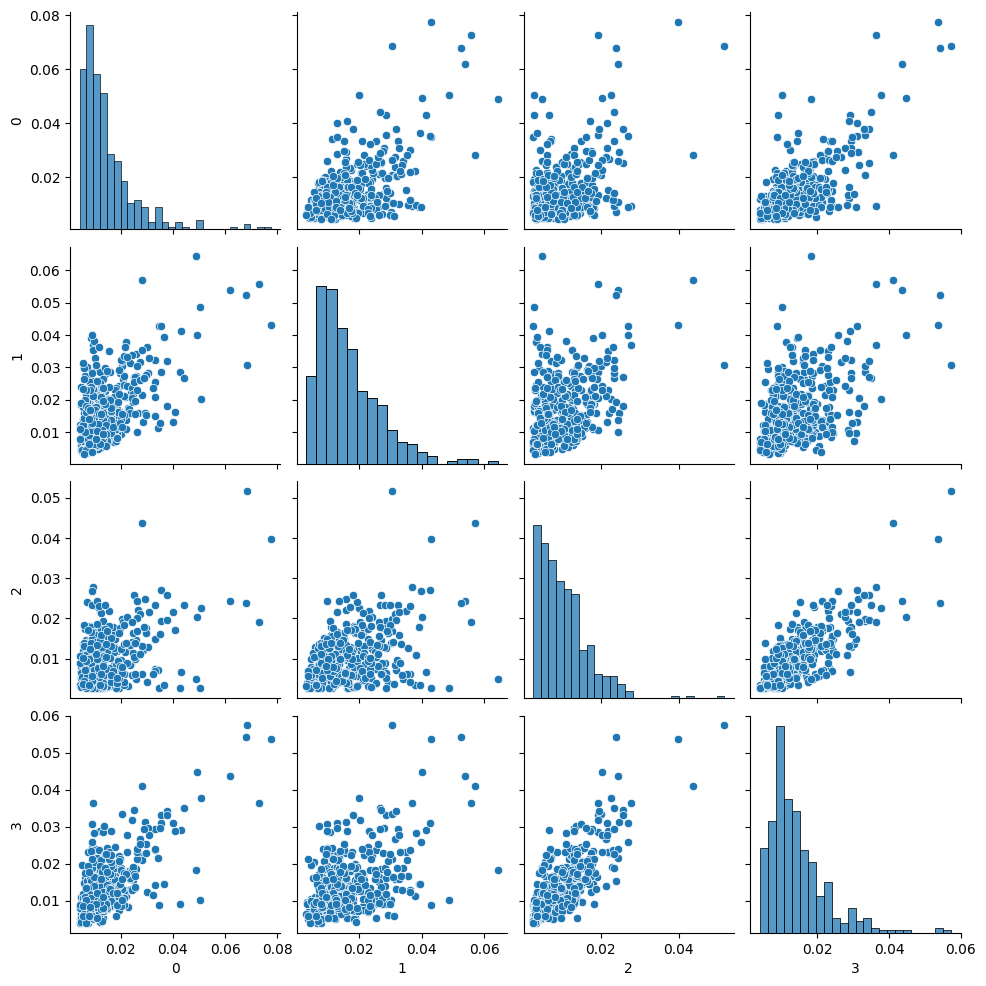

In [13]:
sns.pairplot(pd.DataFrame(sample_results))

In [14]:
pd.DataFrame(sample_results).to_csv("data/generated_results.csv")